# 10.9 Lab: Deep Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as tk
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import sequence
from tensorflow.keras.utils import pad_sequences
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model

%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

2022-11-07 14:48:26.600121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 14:48:26.804649: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 14:48:27.513005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-07 14:48:27.513138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
""" 
In Python, we use keras as the DL interface with backend Tensorflow.
pip install keras 
pip install tensorflow
"""

' \nIn Python, we use keras as the DL interface with backend Tensorflow.\npip install keras \npip install tensorflow\n'

## 10.9.1 A Single Layer Network on the Hitters Data

In this exercise, we will use Hitters data set to predict the salary of a player. 
I will skip the linear regression and Lasso part since we covered them in previous chapters

In [4]:
# read the data and take a look at the data and split it into train and test 
# I copied the code from chapter (because of laziness :- )
Hitters = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

To fit the neural network, we first set up a model structure that describes the network.

We have created a vanilla model object called `model`, and have added details about the successive layers in a sequential manner, using the function `add()`.

We now return to our neural network. The object `model` has a single hidden layer with 50 hidden units, and
a ReLU activation function. It then has a dropout layer, in which a random 40% of the 50 activations from the previous layer are set to zero during each iteration of the stochastic gradient descent algorithm. Finally, the output layer has just one unit with no activation function, indicating that the model provides a single quantitative output.

Next we add details to  `model` that control the fitting algorithm. Here we have simply followed the examples given in
the Keras book. We minimize squared-error loss as in (10.22). The algorithm tracks the mean absolute error on the training data, and on validation data if it is supplied.

In [5]:
# the DL model is similar to other models implemeted in sklearn. 
# we first define the model, then fit the model, and finally predict the result

"""
I am listing out the hyperameters to be tuned. 
From this simple example with only one layer, we could get a sense of the number of hyperameters in NN.

Actually the number of the hyperameters gets exponentially larger as the number of layers increases.
"""
# define the model.model.add
dropout_rate = 0.4
first_layout = 50
epochs = 150
batch_size = 32
activation = 'relu'
loss = 'mean_squared_error'
optimizer = 'rmsprop'
metrics = ['mae']

model = Sequential()
model.add(Dropout(rate=dropout_rate, input_shape=(X_train.shape[1],)))
model.add(Dense(first_layout, activation=activation))
model.add(Dense(1))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
# we can use the model.summary() to see the structure of the model
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 19)                0         
                                                                 
 dense (Dense)               (None, 50)                1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________
None


2022-11-07 14:48:28.969447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-07 14:48:28.969473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-07 14:48:28.970084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In the previous line, we pass `loss,optimzer,metric` as the arguments to `compile()`.

Now we fit the model. We supply the training data and  two fitting parameters, `epochs` and `batch\_size`. Using 32
for the latter means that at each step of SGD, the algorithm randomly selects 32 training observations for the computation of the gradient. Recall from Sections 10.4 and 10.7 that an epoch amounts to the number of SGD steps required to process $n$
observations. Since the training set has $n=176$, an epoch is $176/32=5.5$ SGD steps. 

The `fit()` function has an argument `validation_data`; these data are not used in the fitting, but can be used to track the progress of the model (in this case reporting mean absolute error). Here we actually supply the test data so we can see mean absolute error of both the training data and test data as the epochs proceed.

In [6]:
# fit the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/150
3/3 [==============================] - 0s 3ms/step - loss: 221269.0156 - mae: 312.3691
Epoch 2/150
3/3 [==============================] - 0s 2ms/step - loss: 218240.1094 - mae: 308.6030
Epoch 3/150
3/3 [==============================] - 0s 2ms/step - loss: 192338.5156 - mae: 285.6575
Epoch 4/150
3/3 [==============================] - 0s 2ms/step - loss: 167252.0000 - mae: 250.8797
Epoch 5/150
3/3 [==============================] - 0s 2ms/step - loss: 156044.0938 - mae: 268.6242
Epoch 6/150
3/3 [==============================] - 0s 3ms/step - loss: 136415.7500 - mae: 252.8336
Epoch 7/150
3/3 [==============================] - 0s 3ms/step - loss: 165945.9219 - mae: 263.6606
Epoch 8/150
3/3 [==============================] - 0s 3ms/step - loss: 126707.4297 - mae: 243.6209
Epoch 9/150
3/3 [==============================] - 0s 2ms/step - loss: 148861.0625 - mae: 264.9919
Epoch 10/150
3/3 [==============================] - 0s 2ms/step - loss: 124628.6328 - mae: 250.1239
Epoch 11/

We can plot the `history` to display the mean absolute error for the training and test data.

In [7]:
model.history.history.keys()

dict_keys(['loss', 'mae'])

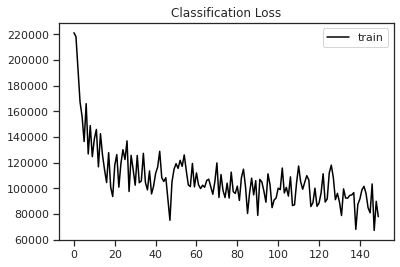

In [8]:
history_dict = model.history.history
plt.title('Classification Loss')
plt.plot(history_dict['loss'], color='black', label='train')
plt.legend(loc='best')
plt.show()

Finally, we predict from the final model, and evaluate its performance on the test data. Due to the use of SGD, the results vary slightly with each fit. Unfortunately, so your results will differ slightly.

In [9]:
# evaluate the model
# model.evaluate returns the loss value & metrics values for the model in test mode.
mse_test, mae_test = model.evaluate(X_test, y_test)
print('Test mse: %.3f, Test mae: %.3f' % (mse_test, mae_test))

6/6 [==============================] - 0s 2ms/step - loss: 150939.5156 - mae: 228.2159
Test mse: 150939.516, Test mae: 228.216


## 10.9.2 A Multilayer Network on the MNIST Digit Data

In [10]:
# we could load the MNIST data set from keras.datasets
# keras.datasets also contains other well-known datasets, such as cifar10, fashion_mnist, etc.
(X_train, y_train), (X_test, y_test) = tk.datasets.mnist.load_data()

In [11]:
# since the data set if for image, so each image is a 28*28 matrix.
print(X_train.shape)
print(np.max(X_train))

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(60000, 28, 28)
255
(60000,)
[0 1 2 3 4 5 6 7 8 9]


There are 60,000 images in the training data and 10,000 in the test data. The images are $28\times 28$, and stored as a three-dimensional array, so we need to reshape them into a matrix.  Also, we need to ``one-hot'' encode the class label. Luckily `keras` has a lot of built-in functions that do this for us.

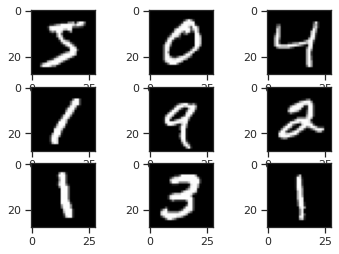

In [12]:
# let us plot some of the images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

Neural networks are somewhat sensitive to the scale of the inputs. For example, ridge and lasso regularization are affected by scaling.  Here the inputs are eight-bit (Note: Eight bits means $2^8$, which equals 256. Since the convention is to start at $0$, the possible values  range from $0$ to $255$.) grayscale values between 0 and 255, so we rescale to the unit interval.

In [13]:
# now let us reshape each image (i.e. matrix) to a vector
X_train = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')
""" 
We know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to 
a range of values from 0 to 1. The simplest way is to divide the value of every pixel by 255 to get the 
values in the range of 0 to 1.
"""
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Now we are ready to fit our neural network.

In [14]:
model = Sequential()
model.add(Dense(256, input_dim = 28 * 28, activation= 'relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(10, activation = 'softmax'))

The first layer goes from  $28\times28=784$ input units to a hidden layer of $256$ units, which uses the ReLU activation function.
This is specified by a call to `add()`, which adds as input a `Dense()` object to the modified `model` object. 
This is then piped through `Dropout()` to perform dropout regularization. The second hidden layer comes next, with $128$ hidden units, followed by a  dropout layer. The final layer is the output layer, with activation `"softmax"` (10.12) for the 10-class classification problem, which defines the map from the second hidden layer to class probabilities. Finally, we use `summary()` to summarize the model, and to make sure we got it all right.

In [15]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None


The parameters for each layer include a bias term, which results in a parameter count of 235,146. For example, the first hidden
layer involves $(784+1)\times 256=200{,}960$ parameters.

Notice that the layer names such as `dropout_1` and `dense_2` have subscripts. These may appear somewhat random; in
fact, if you fit the same model again, these will change. 

Next, we add details to the model to specify the fitting algorithm. We fit the model by minimizing the cross-entropy function given by (10.13).

In [16]:
# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Now we are ready to go. The final step is to supply training data, and fit the model.

In [17]:
history_model = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3262 - accuracy: 0.9032 - val_loss: 0.1354 - val_accuracy: 0.9613
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1873 - accuracy: 0.9489 - val_loss: 0.1124 - val_accuracy: 0.9701
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1678 - accuracy: 0.9575 - val_loss: 0.1247 - val_accuracy: 0.9709
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1620 - accuracy: 0.9624 - val_loss: 0.1139 - val_accuracy: 0.9733
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1588 - accuracy: 0.9642 - val_loss: 0.1094 - val_accuracy: 0.9755
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1538 - accuracy: 0.9660 - val_loss: 0.1253 - val_accuracy: 0.9750
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1539 - accuracy: 0.9668 - val_loss: 0.1217 - val_accuracy:

In [18]:
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1783 - accuracy: 0.9774
Test accuracy: 0.977


We have suppressed the output here, which is a progress report on the fitting of the model, grouped by epoch. This is very useful, since on large datasets fitting can take time. Fitting this model took 144 seconds on a 2.9GHz MacBook Pro with 4 cores and 32 GB of RAM. Here we specified a validation split of 20%, so the training is actually performed on 80% of the 60,000 observations in the training set. This is an alternative to actually supplying validation data, like we did in
Section 10.9.1. SGD  uses batches of 128 observations in computing the gradient, and doing the arithmetic, we see that an epoch corresponds to 375 gradient steps. 

The last `plot()` command produces a figure similar to Figure 10.18.

To obtain the test error in Table 10.1, we first write a simple function `accuracy()` that compares predicted and true
class labels, and then use it to evaluate our predictions.

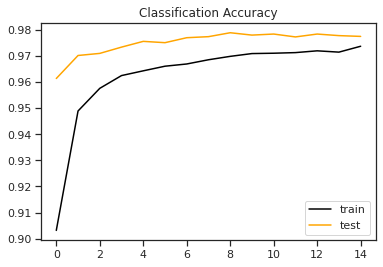

In [19]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

One thing to notice is the test accuracy is actually higher than the training accuracy. It is kind of uncommon - can you thing of a good explaination for this?


## 10.9.3 Convolutional Neural Networks

In this section we fit a CNN to the `CIFAR` data, which is available in the `keras` package. It is arranged in a similar fashion as the `MNIST` data.

In [20]:
(X_train, y_train), (X_test, y_test) = tk.datasets.cifar100.load_data()

In [21]:
# take a look at the data shape, compare to MNIST, this dataset is also image but with 
# different channels, i.e. squared image with 32×32 pixels and three color channels
print(X_train.shape)
print(np.max(X_train))

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
255
(50000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


The array of 50,000 training images has four dimensions:   each three-color image is represented as a set of three channels, each of which consists of $32\times 32$ eight-bit pixels. We standardize as we did for the digits, but keep the array structure. We one-hot encode the response factors  to produce a 100-column binary matrix.

Before we start, we look at some of the training images using  the `imshow; similar code produced Figure 10.5 on page 411.

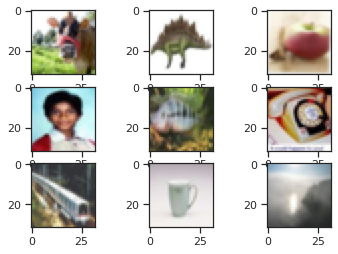

In [22]:
# show a few samples
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [23]:
# the workflow is similar to before
# we prepare the data 
# then define the model architecture 
# then fit the model 
# then exam the model performance 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Here we specify a moderately-sized  CNN for demonstration purposes, similar in structure to Figure 10.8.

In [24]:
# this is a 3 block (each block contains conv layer and pooling layer) VGG architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

# then define the output classifer part of the model 
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(100, activation='softmax'))

model.build((None,32,32,3))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

Notice that we used the `padding='same'` argument to `Conv2D()`, which ensures that the output channels have the same dimension as the input channels. There are 32 channels in the first hidden layer, in contrast to the three channels in the input layer. We use a $3\times 3$ convolution filter for each channel in all the layers. Each convolution is followed by a max-pooling layer over $2\times2$ blocks. By studying the summary, we can see that the channels halve in both dimensions after each of these max-pooling operations. After the last of these we have a layer with  256 channels of dimension $2\times 2$. These are then flattened to a dense layer of size 1,024: in other words, each of the $2\times 2$ matrices is turned into a $4$-vector, and put side-by-side in one layer. This is followed by a dropout regularization layer, then another dense layer of size 512, which finally reaches the softmax output layer.

Finally, we specify the fitting algorithm, and fit the model.

In [25]:
# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0)
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

313/313 [==============================] - 2s 5ms/step - loss: 2.4626 - accuracy: 0.3799
Test accuracy: 0.380


This model takes 10 minutes to run and achieves 46% accuracy on the test data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around 75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time to achieve such results.

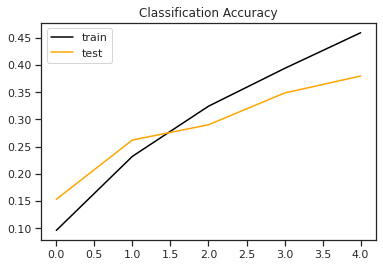

In [26]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

In [27]:
# as before, we can add in dropout 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0)
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

313/313 [==============================] - 2s 5ms/step - loss: 2.6869 - accuracy: 0.3265
Test accuracy: 0.326


From the result, we can see that adding in dropout decreases the test accuracy from 
37.6% to 34.1%. This is mainly due to the underfit of the model.

Dropout helps in the case of overfitting, to see the benefit of the dropout, we would need to 
increase epochs to a large number (~ 1000).

Some other regularization technique is not mentioned in this lab is weight decay (i.e. similar to the concept of Lasso and Ridge)
In this setup, we can add regularization to the weights using the syntax 'kernel_regularizer'
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))

Some other regularization methods are data augmentation and early stopping. 

## 10.9.4 Using Pretrained CNN Models

We now show how to use a CNN pretrained on the  `imagenet` database to classify natural images. 

Instead of using the examples in the book, we choose a VGG model  to make it simple, I used VGG16. There are other pretrained models in this keras.applications class from keras.applications.vgg16 import VGG16

In [28]:
# load model
model = VGG16()
# summarize the model
model.summary()
# fun to check the number of paramters 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We then load the trained network. The model has 50 layers, with a fair bit of complexity.

In [29]:
# load an image from file
!wget https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/dog_test.jpg -N
image = load_img('dog_test.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

--2022-11-07 14:53:59--  https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/dog_test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24849 (24K) [image/jpeg]
Saving to: ‘dog_test.jpg’

dog_test.jpg        100%[===================>]  24.27K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2022-11-07 14:54:00 (41.8 MB/s) - ‘dog_test.jpg’ saved [24849/24849]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


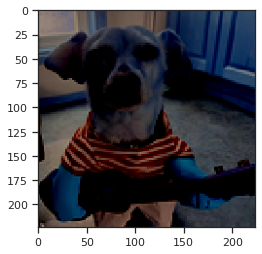

In [30]:
plt.imshow(image[0]/255);

In [31]:
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
print(label)

1/1 [==============================] - 0s 267ms/step
[[('n02099712', 'Labrador_retriever', 0.21460383), ('n04597913', 'wooden_spoon', 0.06297384), ('n02085620', 'Chihuahua', 0.04348557), ('n03481172', 'hammer', 0.041377667), ('n02093256', 'Staffordshire_bullterrier', 0.039868332)]]


Here are other usage on pre-trained models. The example we showed above is to use the model directly to do the prediction. 
Other usage could be as a feature extracter: one example is below. Then we could run other simpler model on top of these features.

In [32]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
features = model.predict(image)
print(features.shape)

1/1 [==============================] - 0s 229ms/step
(1, 4096)


## 10.9.5 IMDb Document Classification

Now we perform document classification (Section ???) on the `IMDB` dataset, which is available as part of the `keras`
package. We  limit the dictionary size to the
10,000  most frequently-used words and tokens.

In [33]:
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=10000)

In [34]:
# take a look at the data shape, compare to MNIST, this dataset is also image but with 
# different channels, i.e. squared image with 32×32 pixels and three color channels
print(X_train.shape)

# the y_train the group label for the training data
print(y_train.shape)
print(np.unique(y_train))

(25000,)
(25000,)
[0 1]


Review length: 
Mean 238.71 words (176.493674)


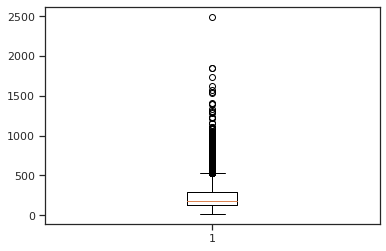

In [35]:
# summarize review length
print("Review length: ")
result = [len(x) for x in X_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [36]:
# we can cap the length of each review at 500
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [37]:
# similar to before, we can build a model. Here I skipped the OHE case, and directly went to use the 
# embedding 
model = Sequential()
model.add(Embedding(10000, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_9 (Dense)             (None, 16)                256016    
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 576,305
Trainable params: 576,305
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# to save compute, I only run 5 epochs
history_model = model.fit(X_train, y_train, epochs=5,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/5
49/49 [==============================] - 2s 32ms/step - loss: 0.6732 - accuracy: 0.5680 - val_loss: 0.5701 - val_accuracy: 0.7230
Epoch 2/5
49/49 [==============================] - 1s 25ms/step - loss: 0.3970 - accuracy: 0.8296 - val_loss: 0.3518 - val_accuracy: 0.8487
Epoch 3/5
49/49 [==============================] - 1s 25ms/step - loss: 0.2334 - accuracy: 0.9097 - val_loss: 0.3044 - val_accuracy: 0.8695
Epoch 4/5
49/49 [==============================] - 1s 25ms/step - loss: 0.1573 - accuracy: 0.9451 - val_loss: 0.3004 - val_accuracy: 0.8724
Epoch 5/5
782/782 [==============================] - 1s 2ms/step - loss: 0.3999 - accuracy: 0.8464
Test accuracy: 0.846


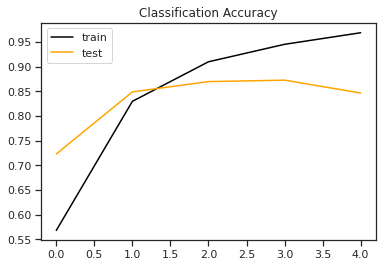

In [39]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

# similar to before, we can add dropout and other regularizations

## 10.9.6 Recurrent Neural Networks

Here we  fit a simple  LSTM RNN for sentiment analysis with
the `IMDB` movie-review data, as discussed in Section 10.5.1. We showed how to input the data in
10.9.5, so we will not repeat that here.

We first calculate the lengths of the documents.

In [40]:
# to expedite the run， I used vocabulary_size = 5000 here 
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = tk.datasets.imdb.load_data(num_words=vocabulary_size)

# we can cap the length of each review at 500
max_words = 500
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100)) # this is the key part of this section: the LSTM layer
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# to save compute, I only run 10 epochs，this takes ~10 mins on my machine. 
# In theory, this RNN setup should produce better results than the CNN setup.
history_model = model.fit(X_train, y_train, epochs=10,
                          batch_size=512, validation_data=(X_test, y_test))
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % acc)

Epoch 1/10
49/49 [==============================] - 101s 2s/step - loss: 0.6587 - accuracy: 0.6711 - val_loss: 0.5030 - val_accuracy: 0.7668
Epoch 2/10
49/49 [==============================] - 97s 2s/step - loss: 0.4979 - accuracy: 0.7900 - val_loss: 0.3740 - val_accuracy: 0.8479
Epoch 3/10
49/49 [==============================] - 96s 2s/step - loss: 0.3776 - accuracy: 0.8449 - val_loss: 0.3780 - val_accuracy: 0.8415
Epoch 4/10
49/49 [==============================] - 96s 2s/step - loss: 0.3214 - accuracy: 0.8687 - val_loss: 0.4356 - val_accuracy: 0.7946
Epoch 5/10
49/49 [==============================] - 95s 2s/step - loss: 0.3106 - accuracy: 0.8733 - val_loss: 0.3736 - val_accuracy: 0.8391
Epoch 6/10
49/49 [==============================] - 96s 2s/step - loss: 0.2693 - accuracy: 0.8942 - val_loss: 0.4021 - val_accuracy: 0.8519
Epoch 7/10
49/49 [==============================] - 96s 2s/step - loss: 0.2772 - accuracy: 0.8931 - val_loss: 0.3478 - val_accuracy: 0.8531
Epoch 8/10
49/49 [=

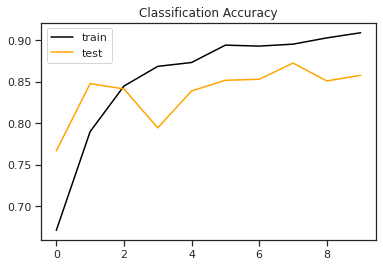

In [42]:
# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

In [43]:
# End of Chapter 10

# TODO

###  Time Series Prediction

We now show how to fit the models in Section ???
for  time series prediction.
We first set up the data, and standardize each of the variables.

The  variable `istrain` contains a `TRUE` for each year that  is in the training set, and a `FALSE` for each year
 in the test set.

We first write functions to create lagged versions of the three time series.  We start with a function that takes as input a data
matrix and a lag $L$, and returns a lagged version of the matrix. It
simply inserts $L$ rows of `NA` at the top, and truncates the
bottom.

We now use this function to create a data frame with all the required
lags, as well as the response variable.

If we look at the first five rows of this frame, we will see some
missing values in the lagged variables (due to the construction above). We remove these rows, and adjust `istrain`
accordingly.

We now fit the linear AR model to the training data using `lm()`, and predict on the
test data.

The last two lines compute the $R^2$ on the test data, as defined in (3.17).

We refit this model, including the factor variable `day_of_week`.

To fit the RNN, we need to reshape these data, since it expects a
sequence of $L=5$ feature vectors $X=\{X_\ell\}_1^L$ for each observation, as in (10.20) on
page  428. These are  lagged versions of the
time series going back $L$ time points.

We have done this in four steps. The first simply extracts the
$n\times 15$ matrix of lagged versions of the three predictor
variables from `arframe`. The second converts this matrix to a
$n\times 3\times 5$ array. We can do this by simply changing the
dimension attribute, since the new array is filled column wise. The
third step reverses the order of lagged variables, so that index $1$
is furthest back in time, and index $5$ closest. The
final step rearranges the coordinates of the array (like a partial
transpose) into the format that the RNN module in `keras`
expects.

Now we are ready to proceed with the RNN, which uses 12 hidden units.

We specify two forms of dropout for the units feeding into the  hidden
 layer. The first is for
the input sequence feeding into this layer, and the second is for the
previous hidden units feeding into the layer.
The output layer has a single unit for the response.

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.

This model takes about one minute to train.

We could replace the  `keras_model_sequential()`  command above with the following command:

Here, `layer_flatten()` simply takes the input sequence and
turns it into a long vector of predictors. This results in a linear AR model.
To fit a nonlinear AR model, we could add in a hidden layer.

However, since we already have the matrix of lagged variables from the AR
model that we fit earlier using the `lm()` command, we can actually fit a nonlinear AR model without needing to perform flattening.
We extract the model matrix `x` from `arframed`, which
includes the `day_of_week` variable.

The `-1` in the formula avoids the creation of a column of ones for
the intercept. The variable `day\_of\_week` is a five-level
factor (there are five trading days), and the
 `-1` results in  five rather than four dummy variables.

The rest of the steps to fit a nonlinear AR model should by now be familiar.